In [55]:
import tensorflow as tf
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import sys
import copy

sys.path.insert(0, '../training')
from shared_funcs import multi_label_binary_encode_tensor, multi_label_binary_decode_tensor, get_waveform

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
tf.config.experimental.set_memory_growth(gpus[1], True)

AUTOTUNE = tf.data.AUTOTUNE

In [56]:
INPUT_AUDIO_DIR = os.path.dirname(os.getcwd()) + "/data-manipulation/supp/input/audio/"
INPUT_META_DIR = os.path.dirname(os.getcwd()) + "/data-manipulation/supp/input/metadata/"

if not os.path.exists(INPUT_AUDIO_DIR):
    os.makedirs(INPUT_AUDIO_DIR)
if not os.path.exists(INPUT_META_DIR):
    os.makedirs(INPUT_META_DIR)

## Define functions
Mainly pulled from model.ipynb

In [ ]:
ALL_LABELS = tf.constant(['p', 'g', 'slash', '7', 'equal', 'w', 'a', 'dash', 'caps', 'l', 'd', 'backspace', 'bracketclose', 'z', '1', 'comma', 'c', 'tab', 'b', 'j', 'Lctrl', 'n', 't', 'f', 'm', 'o', 'apostrophe', 'y', '8', 'space', 'backslash', 's', '9', 'i', 'r', 'bracketopen', 'semicolon', 'q', '5', 'k', '3', 'x', '4', '6', '2', 'Lshift', 'backtick', 'enter', 'fullstop', 'e', '0', 'h', 'v', 'u'], dtype=tf.string)

In [58]:
def load_audio_data():
    data = []
    for file in os.listdir(INPUT_AUDIO_DIR):
        split_fn = file.split("-")
        split_fn[1] = split_fn[1][:-4] # Remove .wav extension
        split_fn[0] = float(split_fn[0])
        split_fn[1] = float(split_fn[1])
        data.append({"start_time": datetime.fromtimestamp(split_fn[0]),
                      "end_time": datetime.fromtimestamp(split_fn[1]),
                        "waveform": get_waveform(tf, INPUT_AUDIO_DIR + file)
        })
    
    return data

def loadMetadata():
    metadata = []
    for file in os.listdir(INPUT_META_DIR):
        with open(INPUT_META_DIR + file, "r") as file:
            fdata = file.readlines()

        for line in fdata:
            line = line.strip("\n").split(",")
            metadata.append({"label": multi_label_binary_encode_tensor(tf, line[0]), "time": datetime.fromtimestamp(float(line[1]))})
    return metadata

# Remove keypresses keylogged outside of recording time and remove keypresses not in ALL_LABELS
def filterMetadata(audio_data, metadata):
    filtered_metadata = []
    for mdata in metadata:
        # Check if label in ALL_LABELS
        label_to_check = tf.constant(multi_label_binary_decode_tensor(tf, mdata["label"])[0], dtype=tf.string)
        if ~tf.reduce_any(tf.equal(ALL_LABELS, label_to_check)):
            continue

        # Check audio_data to match timestamp
        for audio_ts in audio_data:
            start_time = audio_ts["start_time"]
            end_time = audio_ts["end_time"]
            timestamp = mdata["time"]
            if start_time <= timestamp <= end_time:
                filtered_metadata.append(mdata)
    return filtered_metadata

def matchMetadataToAudioSlice(audio_slice, metadata):
    matched_metadata = []
    start_time = audio_slice["start_time"]
    end_time = audio_slice["end_time"]

    for mdata in metadata:
        mdata_ts = mdata["time"]
        if start_time <= mdata_ts <= end_time:
            matched_metadata.append(mdata)

    return matched_metadata


## Load Raw Data

In [59]:
audio_data = load_audio_data()
metadata = filterMetadata(audio_data, loadMetadata())

## Audio Preprocessing
Audio Normalization 

In [60]:
# Normalize waveform
def normalize_peak(waveform):
    max_amplitude = tf.reduce_max(tf.abs(waveform))
    return waveform / max_amplitude

# Normalize raw audio data
normalized_audio_data = []
for sample in audio_data:
    sample_copy = copy.deepcopy(sample)
    sample_copy["waveform"] = normalize_peak(sample_copy["waveform"])
    normalized_audio_data.append(sample_copy)

Data Augmentation

In [61]:
def add_noise(waveform, noise_level):
    noise = tf.random.normal(tf.shape(waveform), stddev=noise_level)
    return waveform + noise

def augment_volume(waveform, gain_db):
    gain = 10 ** (gain_db / 20.0)
    return waveform * gain

def augment_waveform(waveform):
    waveform = add_noise(waveform, 0.02)
    waveform = augment_volume(waveform, tf.random.uniform([], -2.0, 2.0))
    return waveform

# Augment the normalized audio data
augmented_audio_data = []
for sample in normalized_audio_data:
    # Take copy of normalized_audio_data
    sample_copy = copy.deepcopy(sample)
    
    sample_copy["waveform"] = augment_waveform(sample_copy["waveform"])
    augmented_audio_data.append(sample_copy)

## Spectrogram Generation

In [62]:
def compute_spectrograms(audio_sample, frame_length=2205, frame_step=1102):
    
    spectrogram = tf.signal.stft(
        audio_sample,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=frame_length
    )

    # Compute magnitude of STFT (Spectrogram)
    spectrogram_magnitude = tf.abs(spectrogram)

    # Normalize spectrogram
    spectrogram_magnitude = tf.math.log(spectrogram_magnitude + 1e-6)  

    # print("STFT Spectrogram Shape:", spectrogram_magnitude.shape)
    return spectrogram_magnitude

# def label_spectrogram(audio_data, meta_data, spectrogram, frame_length, frame_step):
#     sample_rate = 44100
#     tolerance_sec_before = 0.005 # 5 ms
#     tolerance_sec_after = 0.025 # 25 ms

#     num_windows = tf.shape(spectrogram)[0]
    
#     frame_time_ranges = [
#         (i * frame_step / sample_rate, (i * frame_step + frame_length) / sample_rate)
#         for i in range(num_windows)
#     ]

#     spectrogram_labels = []
#     for frame_start, frame_end in frame_time_ranges:
#         frame_labels_binary = tf.zeros(len(ALL_LABELS), dtype=tf.int32)  # Default zero tensor

#         for label_data in meta_data:
#             label_time = (label_data["time"] - audio_data["start_time"]).total_seconds()
#             if (frame_start - tolerance_sec_before) <= label_time <= (frame_end + tolerance_sec_after):
#                 label_index = tf.where(ALL_LABELS == multi_label_binary_decode_tensor(tf, label_data["label"]))
#                 if tf.size(label_index) > 0:
#                     frame_labels_binary = tf.tensor_scatter_nd_update(
#                         frame_labels_binary,
#                         indices=[[label_index[0][0]]],
#                         updates=[1]
#                     )

#         spectrogram_labels.append(frame_labels_binary)
    
#     spectrogram_labels = tf.stack(spectrogram_labels) # Convert to tensor


def label_spectrogram_groups(audio_data, meta_data, num_window_groups, num_windows_in_group, frame_length, frame_step):
    sample_rate = 44100

    labels = []
    group_duration = (num_windows_in_group * frame_step) / sample_rate  # Duration of each group
    for group_idx in range(num_window_groups):
        group_start_time = audio_data["start_time"] + timedelta(seconds=group_idx * group_duration)
        group_end_time = group_start_time + timedelta(seconds=group_duration)
        
        # Add tolerance
        group_start_time = group_start_time - timedelta(milliseconds=5)
        group_end_time = group_end_time + timedelta(milliseconds=10)

        # Check metadata for labels in this time range
        group_labels = tf.zeros_like(meta_data[0]["label"], dtype=tf.int32)  # Initialize empty label
        for entry in meta_data:
            if group_start_time <= entry["time"] < group_end_time:
                group_labels = tf.maximum(group_labels, entry["label"])  # Combine labels (logical OR)

        labels.append(group_labels)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)  # Convert to tensor
    return labels
# Current size: (78, 552)
# Size of data I want: (5, 25)
# I want 25ms windows

    # frame_length = 1103
    # frame_step = 552


    # spectrograms = compute_spectrograms(audio_data["waveform"], 220, 220)
    

# Takes one entry of audio_data and all entries of meta_data and returns a tensor of spectrograms and labels
def generate_spectrogram_and_label(audio_data, meta_data):
    # Parameters for STFT
    frame_length = 220  # 5 ms
    frame_step = 110    # 2.5 ms
    num_windows_in_group = 19  # Number of spectrogram windows to group

    spectrograms = compute_spectrograms(audio_data["waveform"], frame_length, frame_step)
    num_frames = tf.shape(spectrograms)[0]
    num_frequency_bins = tf.shape(spectrograms)[1]

    # Number of groups
    num_window_groups = num_frames // num_windows_in_group

    # Truncate spectrograms to be divisible by num_windows_in_group
    # print(spectrograms.shape)
    # print(num_window_groups * num_windows_in_group)
    spectrograms_trimmed = spectrograms[:num_window_groups * num_windows_in_group]

    # Reshape to group windows
    grouped_spectrograms = tf.reshape(
        spectrograms_trimmed, (num_window_groups, num_windows_in_group, num_frequency_bins)
    )

    # print("Grouped Spectrograms Shape:", grouped_spectrograms.shape)
    label_groups = label_spectrogram_groups(audio_data, meta_data, num_window_groups, num_windows_in_group, frame_length, frame_step)
    # print(label_groups.shape)
    return grouped_spectrograms, label_groups




test_audio_data = [{
    "start_time": datetime(2024, 12, 7, 12, 0, 0),
    "end_time": datetime(2024, 12, 7, 12, 0, 1),
    "waveform": tf.random.normal([44100])  # 1 second of audio
}]

test_metadata = [
    {"label": tf.constant([1, 0, 0, 0, 0], dtype=tf.int32), "time": datetime(2024, 12, 7, 12, 0, 0, 500000)},
    {"label": tf.constant([0, 1, 0, 0, 0], dtype=tf.int32), "time": datetime(2024, 12, 7, 12, 0, 0, 700000)},
]

print("EVAL")
x, y = generate_spectrogram_and_label(test_audio_data[0], test_metadata)
print(x.shape)
print(y.shape)
# print(y)

EVAL
(21, 19, 111)
(21, 5)


## Create Dataset

In [63]:
def create_dataset(audio_data, metadata):
    def gen():
        for audio_slice in audio_data:
            spectrogram_groups, labels = generate_spectrogram_and_label(audio_slice, metadata)
            for i in range(tf.shape(spectrogram_groups)[0]):
                window = spectrogram_groups[i]
                label = labels[i]
                # print(f"Group {i} shape:", window.shape)  # Shape: (5, frequency_bins)

                yield window, label

    output_signature = (
        tf.TensorSpec(shape=(19, 111), dtype=tf.float32),  # Data shape and dtype
        tf.TensorSpec(shape=(62,), dtype=tf.int32)         # Label shape and dtype
    )
    # Create a dataset from the generator
    dataset = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    
    return dataset

In [64]:
merged_audio_data = normalized_audio_data + augmented_audio_data
dataset = create_dataset(merged_audio_data, metadata)
print("Dataset created")
dataset_size = len(merged_audio_data)
print("Dataset size: ", dataset_size)
dataset = dataset.cache()

Dataset created
Dataset size:  1162


### Remove overoccurance of no classification

2024-12-08 15:25:48.447127: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


55
55
Labels in ALL_LABELS but not in my labels: [b'equal']


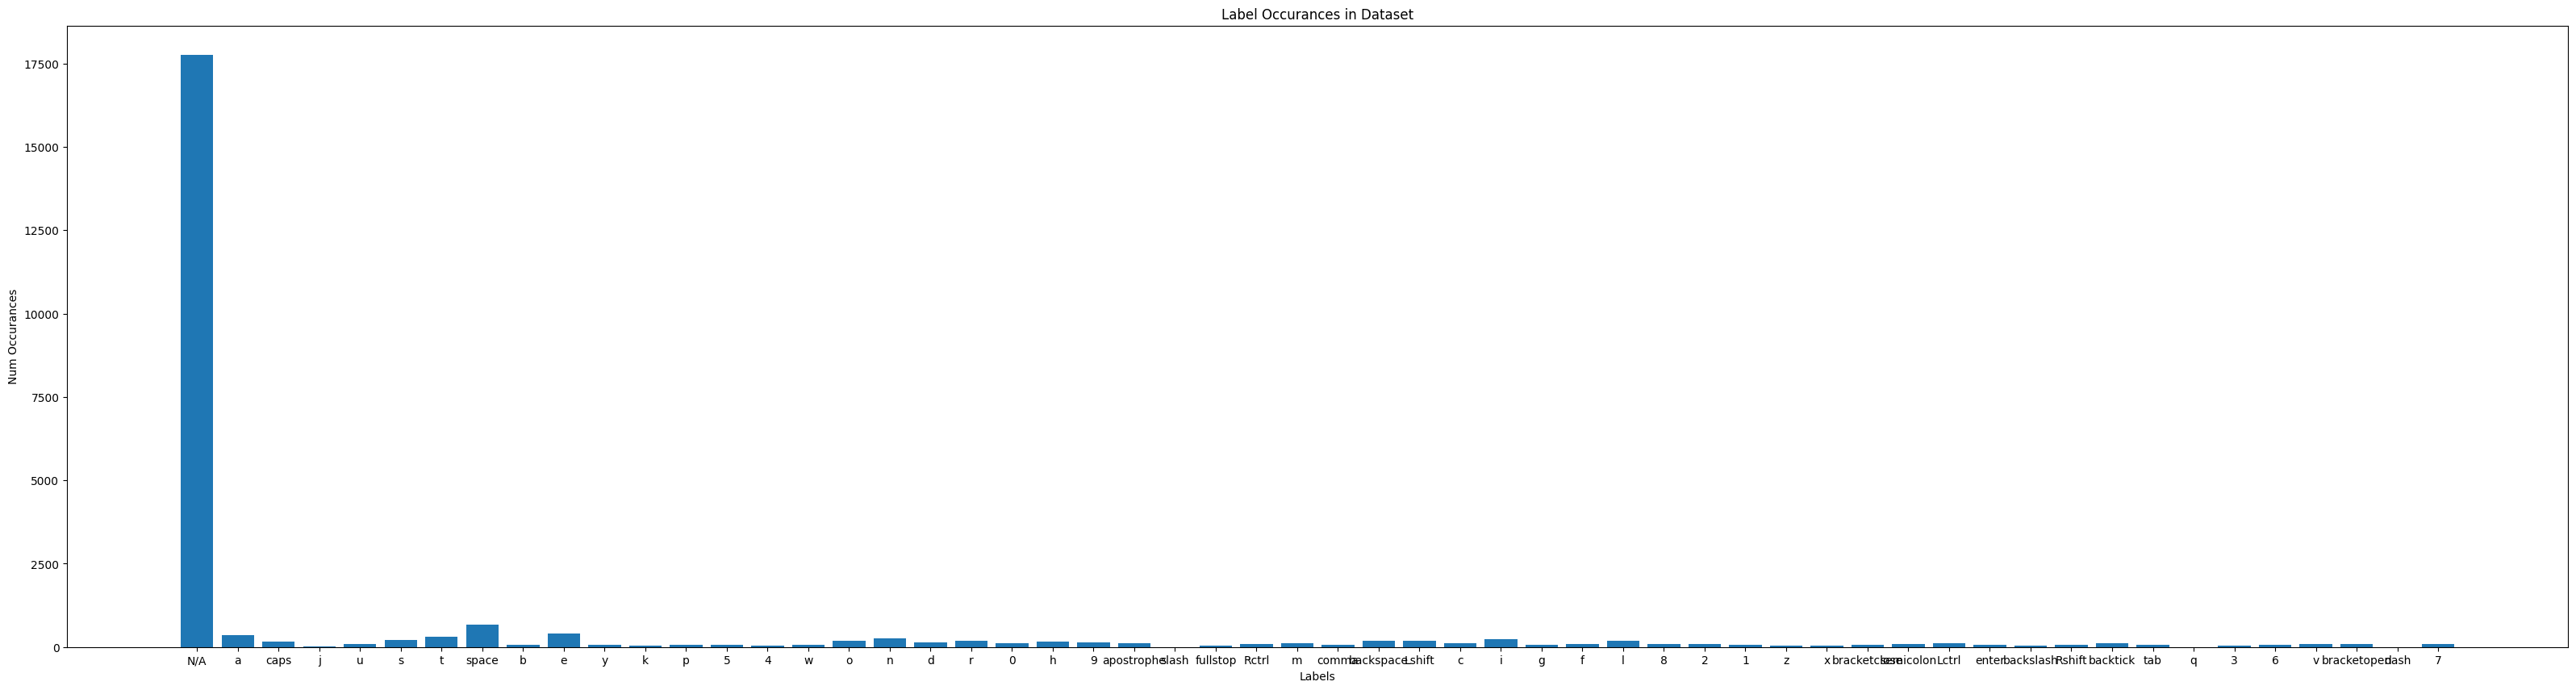

In [65]:
dataset_size = 0
labels = []
label_occurances = []
for spectrogram, label in dataset:
    dataset_size += 1
    label = multi_label_binary_decode_tensor(tf, label)
    if label:
        label = label[0]
        if label in labels:
            index = labels.index(label)
            label_occurances[index] += 1
        else:
            labels.append(label)
            label_occurances.append(1)
print(len(labels))
print(len(label_occurances))

labels_tensor = tf.constant(labels, dtype=tf.string)

difference = tf.sets.difference(tf.expand_dims(ALL_LABELS, axis=0), 
                                tf.expand_dims(labels_tensor, axis=0))

# Convert sparse result to dense
missing_labels = tf.sparse.to_dense(difference)[0].numpy()

print("Labels in ALL_LABELS but not in my labels:", missing_labels)



# Insert no label/noise
labels.insert(0, "N/A")
label_occurances.insert(0, dataset_size - sum(label_occurances))

plt.figure(figsize=(40,10))
plt.bar(labels, label_occurances)
plt.title("Label Occurances in Dataset")
plt.xlabel("Labels")
plt.ylabel("Num Occurances")
plt.show()

### Cache and shuffle

In [66]:

dataset = dataset.shuffle(buffer_size=int(dataset_size / 8), reshuffle_each_iteration=False)
print("Shuffled")
dataset = dataset.prefetch(tf.data.AUTOTUNE)
print("Cached and prefetch")

print(dataset.element_spec)

Shuffled
Cached and prefetch
(TensorSpec(shape=(19, 111), dtype=tf.float32, name=None), TensorSpec(shape=(62,), dtype=tf.int32, name=None))


## Preview Data

#### Waveform Peak Normalization

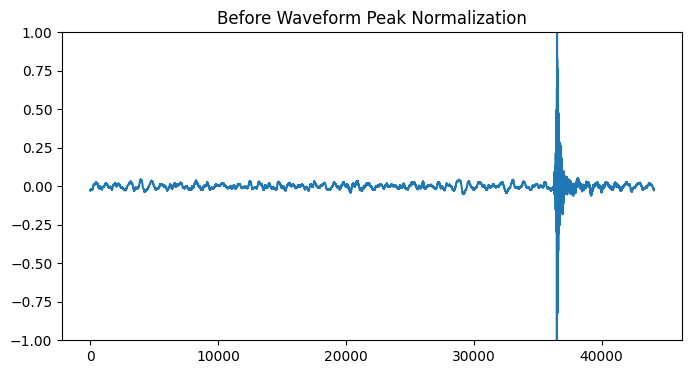

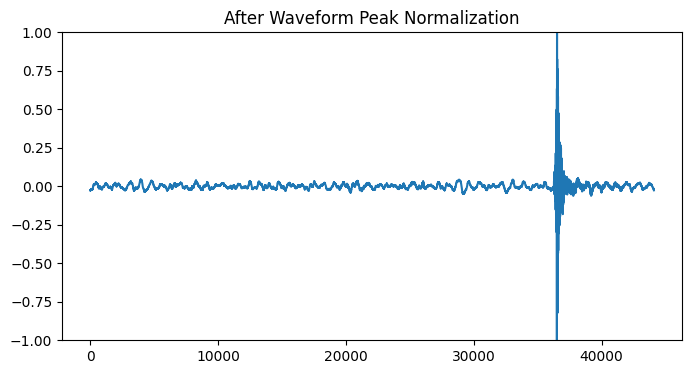

In [67]:
plt.figure(figsize=(8, 4))
plt.title("Before Waveform Peak Normalization")
plt.ylim(-1, 1)
plt.plot(audio_data[0]["waveform"].numpy())

plt.figure(figsize=(8, 4))
plt.title("After Waveform Peak Normalization")
plt.ylim(-1, 1)
plt.plot(normalized_audio_data[0]["waveform"].numpy())

#### Waveform Data Augmentation

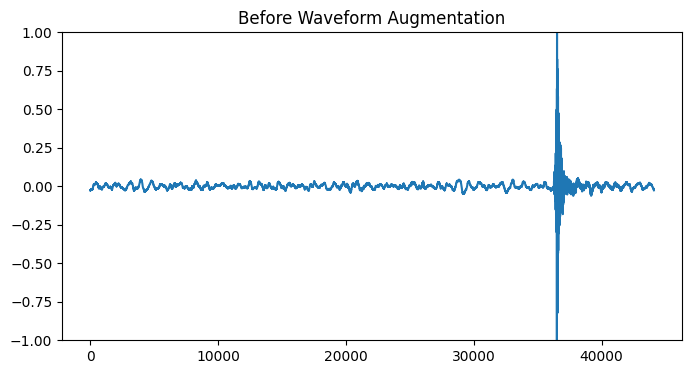

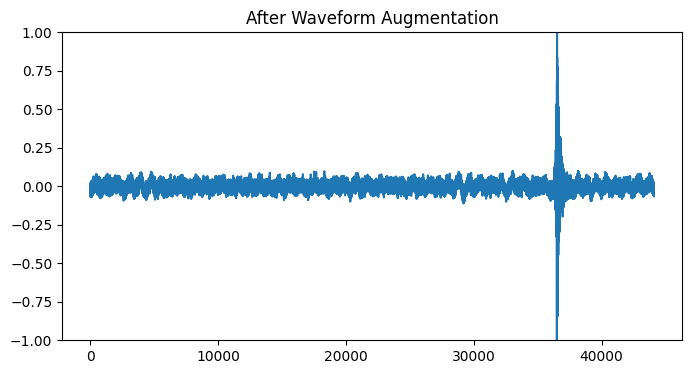

In [68]:
plt.figure(figsize=(8, 4))
plt.title("Before Waveform Augmentation")
plt.ylim(-1, 1)
plt.plot(normalized_audio_data[0]["waveform"].numpy())

plt.figure(figsize=(8, 4))
plt.title("After Waveform Augmentation")
plt.ylim(-1, 1)
plt.plot(augmented_audio_data[0]["waveform"].numpy())

#### Spectrograms

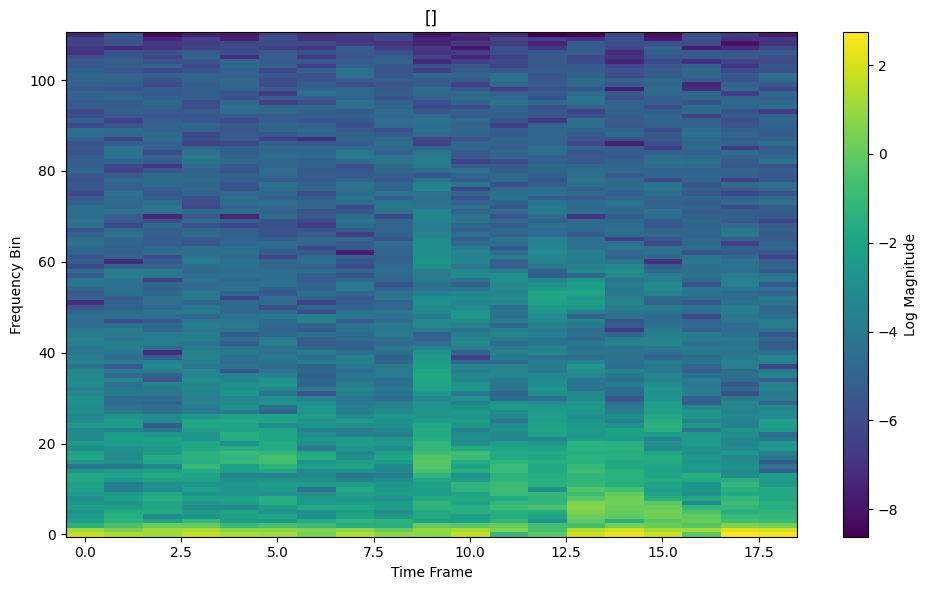

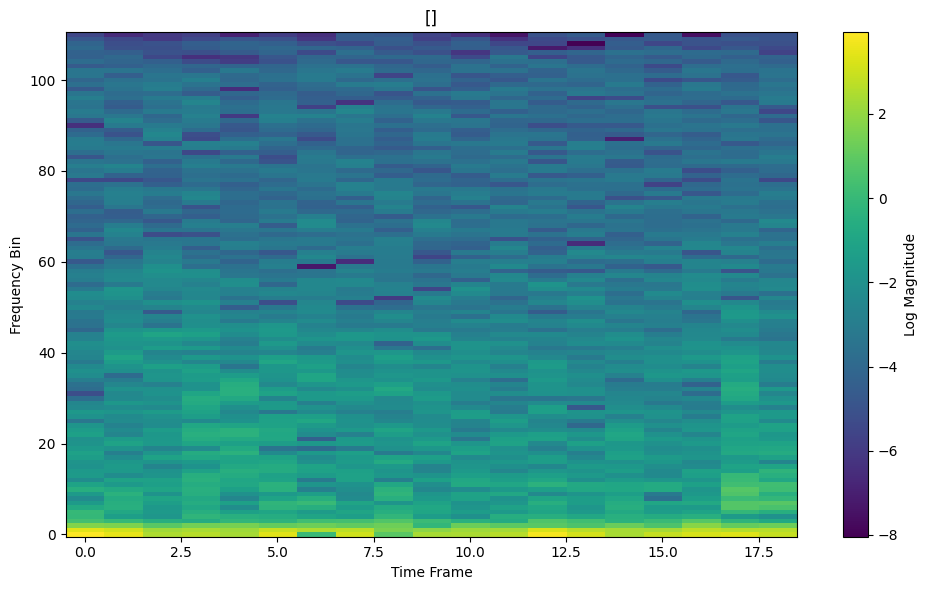

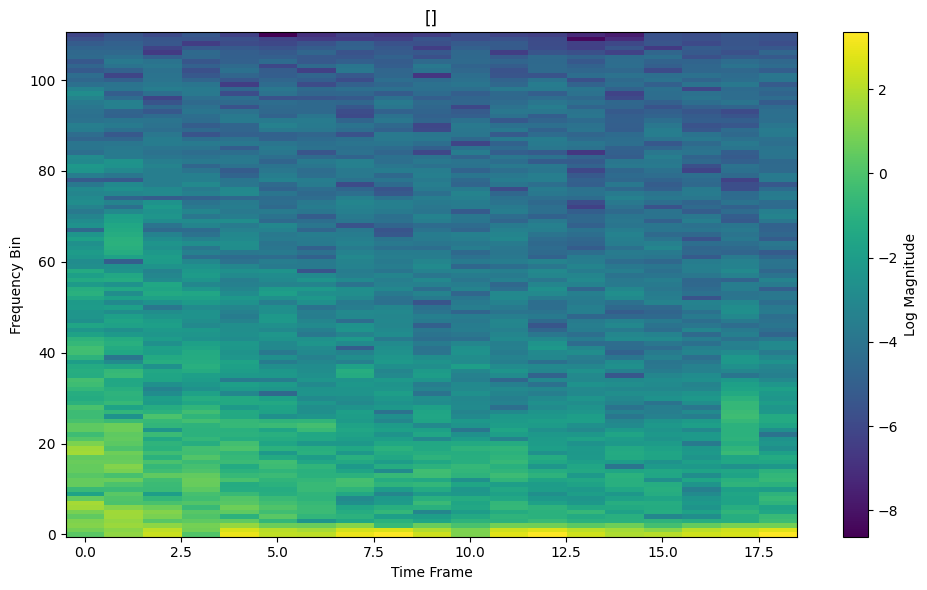

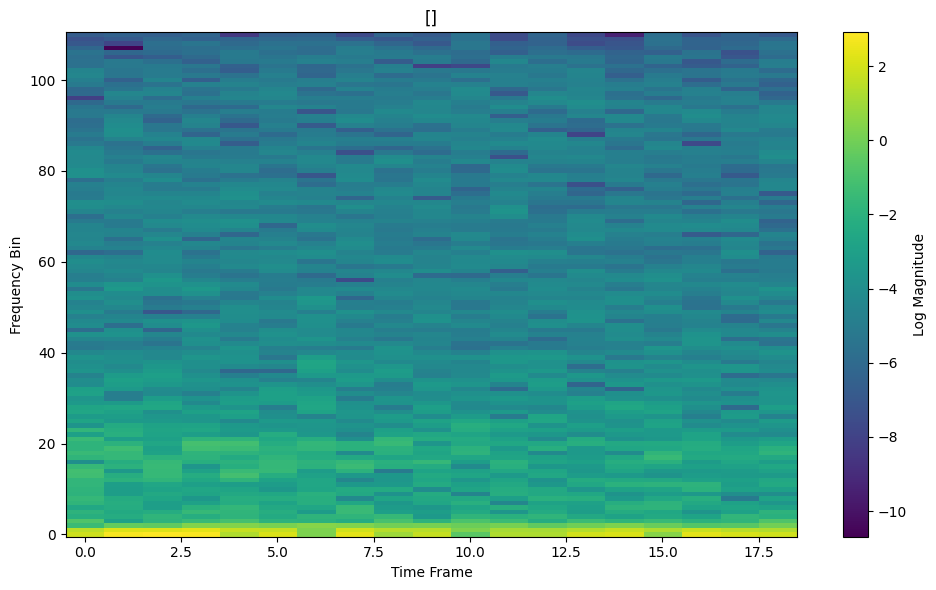

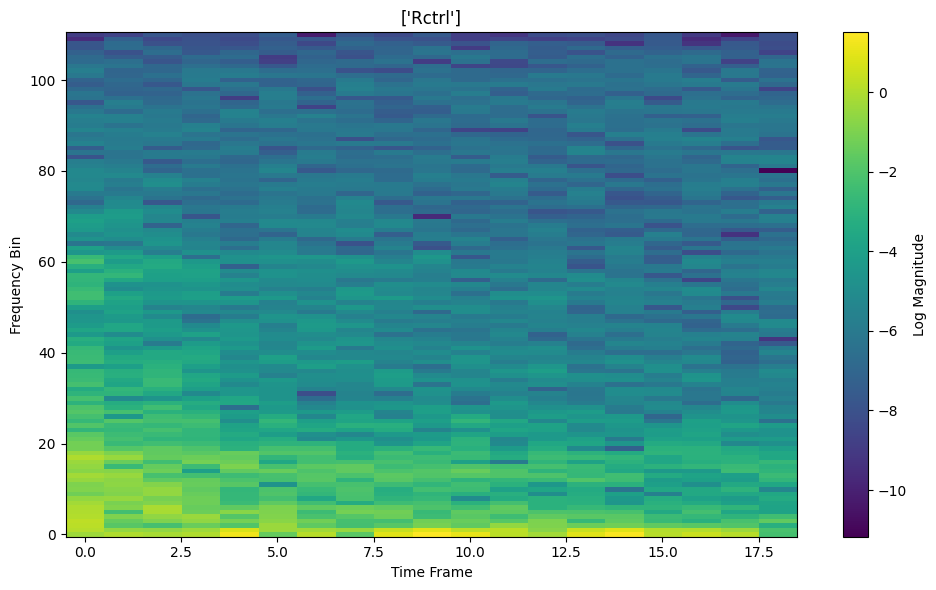

In [69]:
def plot_spectrogram_with_decoded_labels(dataset, num_examples=5):
    for i, (spectrogram, labels) in enumerate(dataset.take(num_examples)):
    # for spectrogram, labels in dataset.take(40000):
    #     if multi_label_binary_decode_tensor(tf, labels) == []:
            # continue
        plt.figure(figsize=(10, 6))
        plt.imshow(spectrogram.numpy().T, aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(label='Log Magnitude')
        plt.title(multi_label_binary_decode_tensor(tf, labels))
        plt.xlabel('Time Frame')
        plt.ylabel('Frequency Bin')
        plt.tight_layout()
        plt.show()

plot_spectrogram_with_decoded_labels(dataset, num_examples=5)

## Save new dataset

In [70]:
path = os.path.dirname(os.getcwd()) + "/data-manipulation/supp_dataset"

dataset.save(path)